# CMIP6 Slice Antartica and Greenland/Iceland

**Following steps are included in this script:**

1. Load netCDF files
2. Remove Antartica by removing data south of 60° and Greenland/Iceland using regionmask
   
4. Save and replace netcdf files

In [3]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import regionmask

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [4]:
def remove_antarctica_greenland_iceland(ds_dict):
    # Define the regions using regionmask
    land_regions = regionmask.defined_regions.ar6.land
    
    # Identify the index for the GIC Greenland/Iceland region
    gic_region_idx = land_regions.map_keys('Greenland/Iceland')
    
    for name, ds in ds_dict.items():
        # Get the mask for the GIC Greenland/Iceland region
        gic_region_mask = land_regions.mask(ds)
        
        # Slice the dataset to exclude Antarctica latitudes
        ds_no_antarctica = ds.sel(lat=(ds.lat > -60))
        
        # Apply the mask to exclude the GIC Greenland/Iceland region
        mask = gic_region_mask == gic_region_idx
        ds_no_gic = ds_no_antarctica.where(~mask, drop=True)

        print(f'Regions removed from {name}.')
        
        # Add comment about changes to data
        if 'log' in ds_no_gic.attrs:
            log_old = ds_no_gic.attrs['log']
            ds_no_gic.attrs['log'] = f'Dataset sliced along lat 60 to remove Antarctica and excluded Greenland and Iceland using regionmask. // {log_old}'
        else:
            ds_no_gic.attrs['log'] = 'Dataset sliced along lat 60 to remove Antarctica and excluded Greenland and Iceland using regionmask.'
        
        ds_dict[name] = ds_no_gic
    
    return ds_dict

### 1. Load netCDF files

In [22]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'year'
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
#variables=['ps', 'huss', 'evspsbl', 'tran', 'gpp', 'tas', 'pr', 'lai', 'mrso', 'mrro'] 
variables=['RX5day']
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

No file found for variable 'RX5day' in model 'GISS-E2-1-G'.
Model 'GISS-E2-1-G' is missing variables: RX5day
No file found for variable 'RX5day' in model 'TaiESM1'.
Model 'TaiESM1' is missing variables: RX5day
[########################################] | 100% Completed | 404.03 ms


['ssp370']


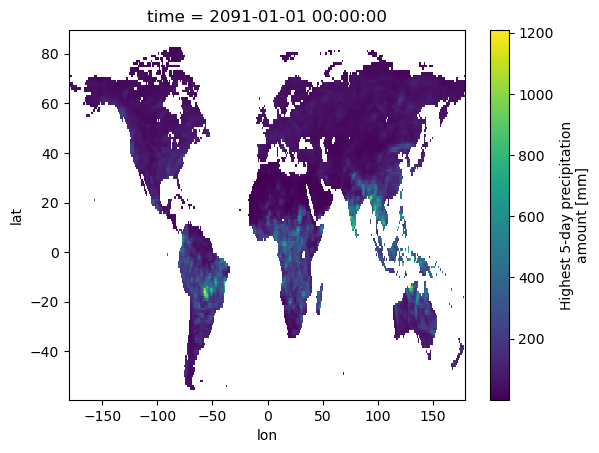

In [24]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[0]].isel(time=20).plot()

### 2. Remove Antartica and Greenland/Iceland

In [10]:
ds_dict = remove_antarctica_greenland_iceland(ds_dict[experiments[0]])

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300115/.conda/envs/mypy3/share/proj failed


In [10]:
# Slice the dataset to exclude Antarctica latitudes
for i, (name, ds) in enumerate(ds_dict.items()):
    ds_no_antarctica = ds.sel(lat=(ds.lat > -60))
    # Add comment about changes to data
    if 'log' in ds_no_antarctica.attrs:
        log_old = ds_no_antarctica.attrs['log']
        ds_no_antarctica.attrs['log'] = f'Dataset sliced along lat 60 to remove Antartica. // {log_old}'
    else:
        ds_no_antarctica.attrs['log'] = 'Dataset sliced along lat 60 to remove Antartica.'
    ds_dict[name] = ds_no_antarctica

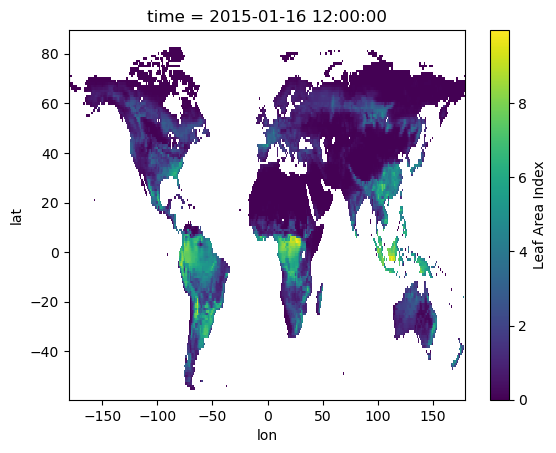

In [30]:
ds_dict[list(ds_dict.keys())[12]][variables[7]].isel(time=0).plot()

### 4. Save and replace netcdf files

In [31]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [32]:
sd.save_files(ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/gpp/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/